In [3]:
# Core libraries
import os
import glob
import time
import random
import shutil

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Saving models
import joblib  # for saving the best SVM model

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Copied the folders locally to make feature extraction faster
!mkdir -p /content/local_images_part_1
!cp /content/gdrive/MyDrive/APS360_SkinCancer_Dataset/HAM10000_images_part_1/*.jpg /content/local_images_part_1/

!mkdir -p /content/local_images_part_2
!cp /content/gdrive/MyDrive/APS360_SkinCancer_Dataset/HAM10000_images_part_2/*.jpg /content/local_images_part_2/


cp: cannot stat '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/HAM10000_images_part_1/*.jpg': No such file or directory
cp: cannot stat '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/HAM10000_images_part_2/*.jpg': No such file or directory


In [15]:

base_path = '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset'

part1_path = os.path.join(base_path, 'HAM10000_images_part_1')
part2_path = os.path.join(base_path, 'HAM10000_images_part_2')


In [12]:
part1_path = '/content/local_images_part_1'
part2_path = '/content/local_images_part_2'


In [16]:
# Image size for EfficientNetB2
IMAGE_SIZE = (260, 260)

# Image preprocessing function
def preprocess_image(image_path, image_size=IMAGE_SIZE):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(image_size)
    image_array = np.array(image) / 255.0
    return image_array

# Step 1: Get all image paths
all_image_paths = glob.glob(os.path.join(part1_path, '*.jpg')) + \
                  glob.glob(os.path.join(part2_path, '*.jpg'))

print(f"Total images found: {len(all_image_paths)}")

Total images found: 9524


Image shape: (260, 260, 3)


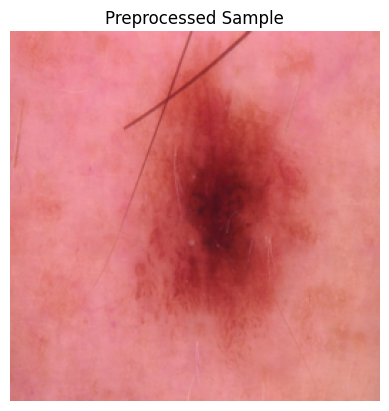

In [17]:
# Test path to one image — update with actual path when dataset is ready
sample_path = "/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/HAM10000_images_part_1/ISIC_0024306.jpg"

img = preprocess_image(sample_path)
print("Image shape:", img.shape)

# Show it
plt.imshow(img)
plt.title("Preprocessed Sample")
plt.axis("off")
plt.show()


In [18]:

# Path to metadata CSV (update if needed)
metadata_path = "/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/HAM10000_metadata.csv"

# Load CSV
df = pd.read_csv(metadata_path)

# Add full filename (e.g., ISIC_0027419.jpg)
df['filename'] = df['image_id'] + '.jpg'

# Rename 'dx' to 'label' for clarity
df = df.rename(columns={'dx': 'label'})

# Preview
print(df[['filename', 'label']].head())


           filename label
0  ISIC_0027419.jpg   bkl
1  ISIC_0025030.jpg   bkl
2  ISIC_0026769.jpg   bkl
3  ISIC_0025661.jpg   bkl
4  ISIC_0031633.jpg   bkl


In [19]:
# Remove any leading/trailing spaces from labels
df['label'] = df['label'].str.strip()

# Create mapping by converting the cancer types to index. It maps indexes to cancer types
label_mapping = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
index_to_label = {v: k for k, v in label_mapping.items()}

print("\nLabel mapping (string to int):")
print(label_mapping)

# Apply the mapping
df['label'] = df['label'].map(label_mapping)

# Check results and see if labels are all converted from strings to int
print("\nAfter mapping:")
print(df[['filename', 'label']].head())
print(df.dtypes)



Label mapping (string to int):
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

After mapping:
           filename  label
0  ISIC_0027419.jpg      2
1  ISIC_0025030.jpg      2
2  ISIC_0026769.jpg      2
3  ISIC_0025661.jpg      2
4  ISIC_0031633.jpg      2
lesion_id        object
image_id         object
label             int64
dx_type          object
age             float64
sex              object
localization     object
filename         object
dtype: object


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

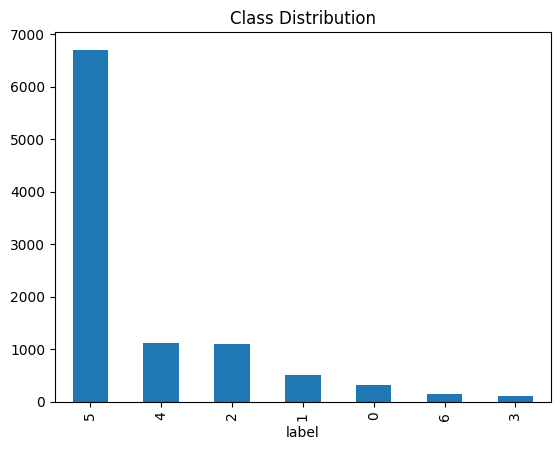

In [ ]:
#optional check
df['label'].value_counts().plot(kind='bar', title='Class Distribution')


In [ ]:
random.seed(36)  # for reproducibility

np.random.shuffle(all_image_paths)

total = len(all_image_paths)
n_train = int(total * 0.7)
n_val = int(total * 0.15)

train_files = set(all_image_paths[:n_train]) #path to training files
val_files = set(all_image_paths[n_train:n_train + n_val]) #path to validation files
test_files = set(all_image_paths[n_train + n_val:]) #path to testing files

print("Train:", len(train_files))
print("Val:", len(val_files))
print("Test:", len(test_files))

Train: 6666
Val: 1428
Test: 1430


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to ResNet size
    transforms.ToTensor(),                 # Convert to tensor
    #recommended for a better feature extraction
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],       # ImageNet mean
        std=[0.229, 0.224, 0.225]         # ImageNet std
    )
])


In [ ]:
class ImagePathDataset(Dataset):

    def __init__(self, file_paths, label_df, transform=None):
        self.transform = transform

        # Clean the label dictionary to have only filename -> integer label
        self.label_dict = dict(zip(label_df['filename'], label_df['label']))

        # Filter and clean file paths that match the label dictionary
        self.file_paths = []
        for path in file_paths:
            cleaned_filename = self._clean_filename(os.path.basename(path)) #removes [1] at the ends of the file paths
            if cleaned_filename in self.label_dict: #if label found add it
                self.file_paths.append(path)
            else:
                print(f"Warning: {cleaned_filename} not found in metadata. Skipping.")

    #Called by DataLoader function
    def __len__(self):
        return len(self.file_paths)

    #Called by DataLoader function
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        filename = self._clean_filename(os.path.basename(path))

        # Get integer label from dictionary
        label = self.label_dict[filename]
        label = torch.tensor(label, dtype=torch.long)  # ensures it's a Tensor

        # Load and transform the image
        img = Image.open(path).convert('RGB')
        img = self.transform(img)

        return img, label

    def _clean_filename(filename):

         # Keep only the part before the '?'
        filename = filename.split('?')[0]
        # Remove duplicate suffixes like (1)
        if ' (' in filename:
            filename = filename.split(' (')[0] + '.jpg'
        #Remove any spaces from start or end of filename
        return filename.strip()


In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)

resnet.eval()

# Remove the last fully connected layer
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)


#This function is for extracting the features from the data given
def save_features(dataloader):
  all_features = []  # store feature tensors
  all_labels = []    # store labels
  n =0

  with torch.no_grad():
      for images, labels in dataloader:
          # Move them to either cpu or cuda depending on the runtime type
          images = images.to(device)
          labels = labels.to(device)

          # Extract features
          feats = feature_extractor(images)         # shape: [batch, 512, 1, 1]
          feats = feats.view(feats.size(0), -1)     # flatten to [batch, 512]

          all_features.append(feats.cpu())
          all_labels.append(labels.cpu())

          #Keep track of the excution
          n=n+1
          print("Done ", n)

  #concatenates multiple tensors
  return torch.cat(all_features), torch.cat(all_labels)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#converts the file paths to data loaders for training
train_dataset = ImagePathDataset(train_files, df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
print(device) #check the device being used

cuda


In [ ]:

#Extract features
features_train, labels_train = save_features(train_loader)

#Save extracted features to a file
torch.save({
    'features': features_train,
    'labels': labels_train
}, '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/train_features.pt')

print("Saved train features to Google Drive!")


Done  1
Done  2
Done  3
Done  4
Done  5
Done  6
Done  7
Done  8
Done  9
Done  10
Done  11
Done  12
Done  13
Done  14
Done  15
Done  16
Done  17
Done  18
Done  19
Done  20
Done  21
Done  22
Done  23
Done  24
Done  25
Done  26
Done  27
Done  28
Done  29
Done  30
Done  31
Done  32
Done  33
Done  34
Done  35
Done  36
Done  37
Done  38
Done  39
Done  40
Done  41
Done  42
Done  43
Done  44
Done  45
Done  46
Done  47
Done  48
Done  49
Done  50
Done  51
Done  52
Done  53
Done  54
Done  55
Done  56
Done  57
Done  58
Done  59
Done  60
Done  61
Done  62
Done  63
Done  64
Done  65
Done  66
Done  67
Done  68
Done  69
Done  70
Done  71
Done  72
Done  73
Done  74
Done  75
Done  76
Done  77
Done  78
Done  79
Done  80
Done  81
Done  82
Done  83
Done  84
Done  85
Done  86
Done  87
Done  88
Done  89
Done  90
Done  91
Done  92
Done  93
Done  94
Done  95
Done  96
Done  97
Done  98
Done  99
Done  100
Done  101
Done  102
Done  103
Done  104
Done  105
Done  106
Done  107
Done  108
Done  109
Done  110
Done  11

In [ ]:
#converts the file paths to data loaders for validation
val_dataset = ImagePathDataset(val_files, df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:

#Extract features
features_val, labels_val = save_features(val_loader)

#Save extracted features to a file
torch.save({
    'features': features_val,
    'labels': labels_val
}, '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/val_features.pt')

print("Saved validation features to Google Drive!")


Done  1
Done  2
Done  3
Done  4
Done  5
Done  6
Done  7
Done  8
Done  9
Done  10
Done  11
Done  12
Done  13
Done  14
Done  15
Done  16
Done  17
Done  18
Done  19
Done  20
Done  21
Done  22
Done  23
Done  24
Done  25
Done  26
Done  27
Done  28
Done  29
Done  30
Done  31
Done  32
Done  33
Done  34
Done  35
Done  36
Done  37
Done  38
Done  39
Done  40
Done  41
Done  42
Done  43
Done  44
Done  45
Saved validation features to Google Drive!


In [ ]:
 #converts the file paths to data loaders for testing
test_dataset = ImagePathDataset(test_files, df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:

#Extract features
features_test, labels_test = save_features(test_loader)

#Save extracted features to a file
torch.save({
    'features': features_test,
    'labels': labels_test
}, '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/test_features.pt')

print("Saved testing features to Google Drive!")


Done  1
Done  2
Done  3
Done  4
Done  5
Done  6
Done  7
Done  8
Done  9
Done  10
Done  11
Done  12
Done  13
Done  14
Done  15
Done  16
Done  17
Done  18
Done  19
Done  20
Done  21
Done  22
Done  23
Done  24
Done  25
Done  26
Done  27
Done  28
Done  29
Done  30
Done  31
Done  32
Done  33
Done  34
Done  35
Done  36
Done  37
Done  38
Done  39
Done  40
Done  41
Done  42
Done  43
Done  44
Done  45
Saved testing features to Google Drive!


In [ ]:

# This function is for performing grid search over C and gamma for SVM
def grid_search_svm_plot(
    X_train, y_train, X_val, y_val,
    C_values, gamma_values
):

    validation_acc = np.zeros((len(gamma_values), len(C_values))) #stores the accuracy

    #keeps track of the best parameters
    best_acc = 0
    best_C = None
    best_gamma = None

    #for every combination of the parameter trains a svm model and checks its accuracy
    for i, gamma in enumerate(gamma_values):
        for j, C in enumerate(C_values):
            svm_model = SVC(kernel='rbf', C=C, gamma=gamma) #defines the SVM model
            svm_model.fit(X_train, y_train) #trains the model
            acc = svm_model.score(X_val, y_val) #checks its validation accuracy
            validation_acc[i, j] = acc

            #if found a model with better validation accuracy saves the parameters as best
            if acc > best_acc:
                best_acc = acc
                best_C = C
                best_gamma = gamma

    # Plot heatmap of validation accuracy for all (C, gamma) combinations
    plt.figure(figsize=(8,6))  # Set the figure size

    plt.imshow(
        validation_acc,                   # 2D grid of accuracies to visualize
        interpolation='nearest',          # No smoothing between cells
        cmap='viridis',                    # Color map for clarity
        extent=[                           # Map grid to log-scale axes
            np.log10(C_values[0]), np.log10(C_values[-1]),
            np.log10(gamma_values[-1]), np.log10(gamma_values[0])
        ]
    )

    plt.colorbar(label='Validation Accuracy')  # Add color scale legend

    plt.xticks(np.log10(C_values), C_values)   # X-axis: label with actual C values
    plt.yticks(np.log10(gamma_values), gamma_values)  # Y-axis: label with actual gamma values

    plt.xlabel('C')                             # Label X-axis
    plt.ylabel('gamma')                         # Label Y-axis
    plt.title('Validation Accuracy Heatmap')    # Add title
    plt.show()                                  # Display the plot


    print(f"Best Validation Accuracy: {best_acc:.4f} with C={best_C}, gamma={best_gamma}")
    return best_C, best_gamma, best_acc

In [ ]:
#This function is for training the best hyperparameters SVM model
def train_svm(features_train, labels_train, features_val, labels_val, features_test, labels_test):

    # Convert PyTorch tensors to NumPy arrays for scikit-learn
    X_train = features_train.numpy() #X represent the features of the images
    y_train = labels_train.numpy()  #y represents the corresponding labels of the images

    # Convert PyTorch tensors to NumPy arrays for scikit-learn
    X_val = features_val.numpy() #X represent the features of the images
    y_val = labels_val.numpy()  #y represents the corresponding labels of the images

    # Convert PyTorch tensors to NumPy arrays for scikit-learn
    X_test = features_test.numpy() #X represent the features of the images
    y_test = labels_test.numpy()  #y represents the corresponding labels of the images

    # Combine features for better training of the final model
    X_train_full = np.concatenate([X_train, X_val], axis=0)

    # Combine labels for better training of the final model
    y_train_full = np.concatenate([y_train, y_val], axis=0)


    print(f"Train set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")

    C_values = [0.01, 0.1, 1, 10, 100]
    gamma_values = [0.001, 0.01, 0.1, 1, 10]

    best_C, best_gamma, best_acc = grid_search_svm_plot(X_train, y_train, X_val, y_val, C_values, gamma_values)
    print(f"Best Hyperparameters Found: C={best_C}, gamma={best_gamma}, Val Accuracy={best_acc:.4f}")

    # Retrain final SVM on bigger training set by adding training and validation data into one set
    svm_model_final = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
    svm_model_final.fit(X_train_full, y_train_full)

    # Evaluate on teesting set
    test_acc = svm_model_final.score(X_test, y_test)
    print(f"Final Test Accuracy: {test_acc:.4f}")

    # Save it to disk
    joblib.dump(svm_model_final, 'best_svm_model.pkl')

    return svm_model_final, test_acc


Train set size: 6666
Validation set size: 1428
Test set size: 1430


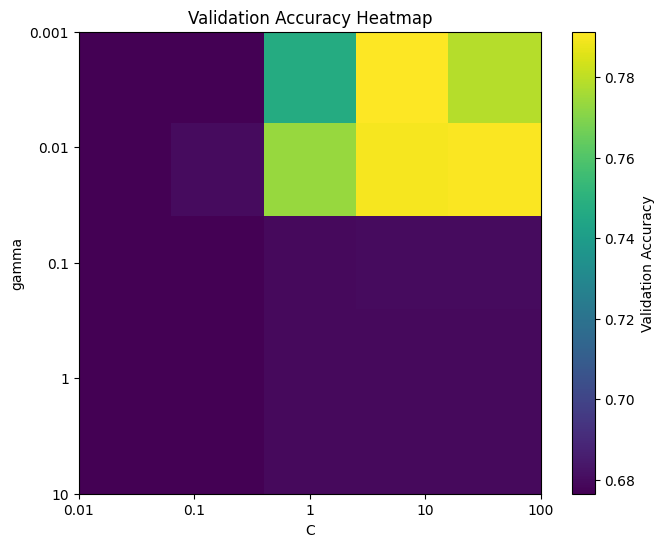

Best Validation Accuracy: 0.7913 with C=10, gamma=0.001
Best Hyperparameters Found: C=10, gamma=0.001, Val Accuracy=0.7913
Final Test Accuracy: 0.7909


(SVC(C=10, gamma=0.001), 0.7909090909090909)

In [ ]:
train_svm(features_train, labels_train, features_val, labels_val, features_test, labels_test)

In [ ]:
!ls /content/best_svm_model.pkl


/content/best_svm_model.pkl


In [ ]:
!mkdir -p '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/Baseline_Model'


In [ ]:
!cp /content/best_svm_model.pkl '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/Baseline_Model'

In [ ]:
!ls '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset//Processed_BaseLine_Data/Baseline_Model'

best_svm_model.pkl


In [3]:
model_path = '/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/Baseline_Model/best_svm_model.pkl'

final_svm = joblib.load(model_path)


In [20]:

# Load saved .pt file for training set features extracted from ResNet
train_data = torch.load('/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/train_features.pt')

# Get the tensors
train_features = train_data['features']
train_labels = train_data['labels']

# Load saved .pt file  for validation set features extracted from ResNet
val_data = torch.load('/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/val_features.pt')

# Get the tensors
val_features = val_data['features']
val_labels = val_data['labels']

# Load saved .pt file for testing set features extracted from ResNet
test_data = torch.load('/content/gdrive/MyDrive/APS360_SkinCancer_Dataset/Processed_BaseLine_Data/test_features.pt')

# Get the tensors
test_features = test_data['features']
test_labels = test_data['labels']

In [21]:
# Combine features for better training of the final model
train_full_features = np.concatenate([train_features, val_features], axis=0)

# Combine labels for better training of the final model
train_full_labels = np.concatenate([train_labels, val_labels], axis=0)


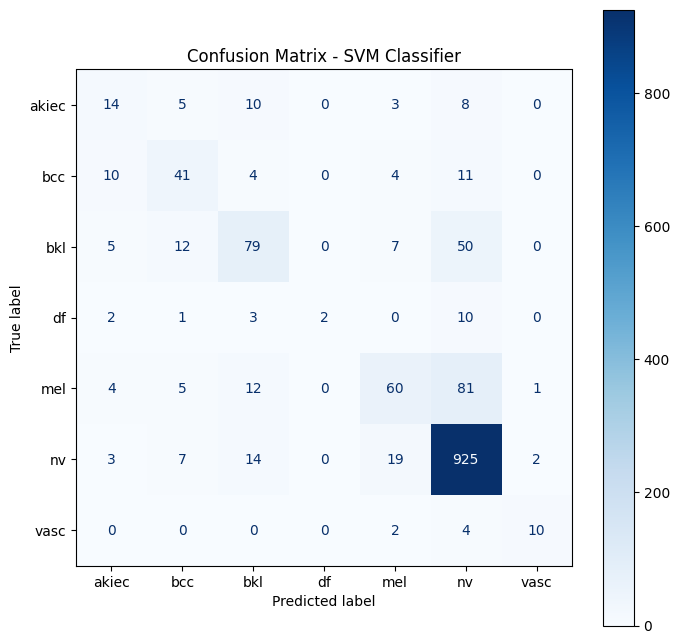

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
test_pred = final_svm.predict(test_features)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Get class labels
class_names = [index_to_label[i] for i in sorted(index_to_label.keys())]

# Plot the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - SVM Classifier')
plt.show()


In [22]:

# This function returns true , predicted labels, and predicted class probabilities from the SVM model
def get_svm_predictions_and_probabilities(model, features, labels):

    # Convert tensors to numpy
    X = features.numpy()
    y_true = labels.numpy()

    # Predict classes and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    return y_true, y_pred, y_proba


In [23]:
from sklearn.metrics import f1_score, classification_report

#This function calculates and then prints weighted average F1-score
def print_f1(y_true, y_pred, class_names):

    weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\nWeighted Average F1 Score: {weighted_f1:.4f}")

    print("\nFull Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# This function is for plotting a histogram of model confidence
def plot_confidence_distribution(y_true, y_pred, y_proba):


    # Get predicted class confidence
    predicted_confidences = np.max(y_proba, axis=1)

    # Determine if its correct
    is_correct = (y_pred == y_true)

    # Split the data
    correct_confidences = predicted_confidences[is_correct]
    incorrect_confidences = predicted_confidences[~is_correct]

    plt.figure(figsize=(10, 6))
    sns.histplot(correct_confidences, color='skyblue', label='Correct Predictions', kde=True, stat='density', bins=20, alpha=0.6)
    sns.histplot(incorrect_confidences, color='salmon', label='Incorrect Predictions', kde=True, stat='density', bins=20, alpha=0.6)
    plt.title('Confidence Distribution for Correct vs. Incorrect Predictions (SVM)')
    plt.xlabel('Predicted Class Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.show()



Weighted Average F1 Score: 0.7727

Full Classification Report:
              precision    recall  f1-score   support

       akiec       0.37      0.35      0.36        40
         bcc       0.58      0.59      0.58        70
         bkl       0.65      0.52      0.57       153
          df       1.00      0.11      0.20        18
         mel       0.63      0.37      0.47       163
          nv       0.85      0.95      0.90       970
        vasc       0.77      0.62      0.69        16

    accuracy                           0.79      1430
   macro avg       0.69      0.50      0.54      1430
weighted avg       0.78      0.79      0.77      1430



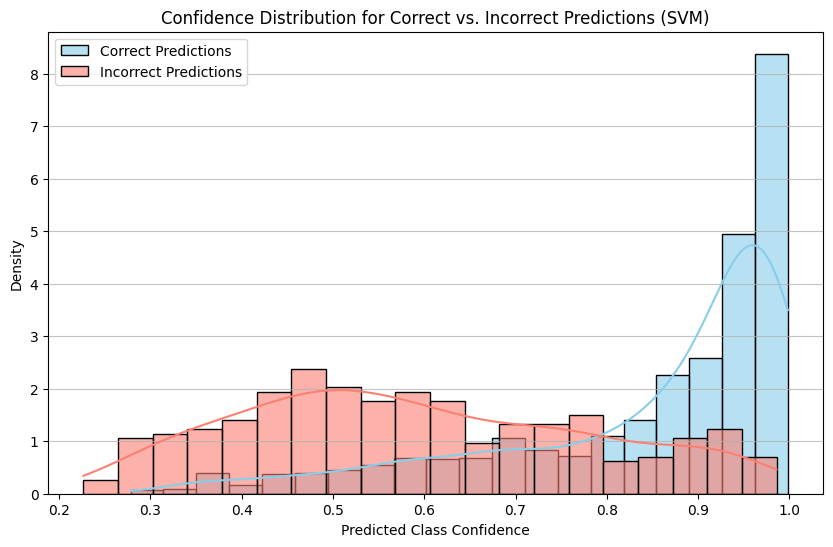

In [25]:
# Retrain final SVM on Train+Validation but also allowing prbability so that can generate classfication report
svm_model_final = SVC(kernel='rbf', C=10, gamma=0.001, probability=True)
svm_model_final.fit(train_full_features, train_full_labels)

y_true, y_pred, y_proba = get_svm_predictions_and_probabilities(svm_model_final, test_features, test_labels)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print_f1(y_true, y_pred, class_names)
plot_confidence_distribution(y_true, y_pred, y_proba)
